### ***Import Libarays***

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from IPython.display import clear_output
clear_output()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

import torch
import os
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from transformers import  get_cosine_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

import warnings
warnings.simplefilter("ignore", category=FutureWarning)
print('compelet')


2025-06-02 18:58:24.813518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748890705.235741      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748890705.351014      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


compelet


### ***Data Exploring***

In [3]:
# Load the dataset
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
df.duplicated().sum()

418

In [8]:
df.drop_duplicates(inplace=True)

***We notice that***
 * the data is balanced , have 50K rows 25K postive and 25K negative.
 * there no null values 
 * there are some dublicates and drop them 
 

### ***Data Preprocessing***

####  ***Text Cleaning***
  * remove some unuseful parts from text like links , html_tags ,extra space ,...

In [9]:

def preprocess_cleaning(text):
    # remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    text = text.lower()
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # remove user mentions and hashtags
    text = re.sub(r'@\w+|\#', '', text)
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#### ***Remove custom stopwords***
  * keep the negative stop words as it has great influence in analysis such as "like this" , "don't like this" 

In [10]:
stop_words = set(stopwords.words('english'))
negatives = {
    "no", "not", "nor", "neither", "none", "never", "nobody", "nowhere", "nothing",
    "don't", "doesn't", "didn't", "won't", "wouldn't", "can't", "couldn't",
    "isn't", "aren't", "wasn't", "weren't", "haven't", "hasn't", "hadn't",
    "shouldn't", "mustn't", "mightn't", "needn't", 'don', 'won', 'aren', 'couldn',
    'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'mightn', 'mustn', 'needn', 
    'shan', 'shouldn', 'wasn', 'weren', 'wouldn'
}
custom_stop_words = stop_words - negatives

def preprocess_stopwords(text):
    # Tokenize
    tokens = word_tokenize(text)
    # remove custom stopwords
    tokens = [word for word in tokens if word not in custom_stop_words]
    # Return tokens as a string
    return ' '.join(tokens)

In [11]:

def preprocess_text(text):
    text = preprocess_cleaning(text)
    text = preprocess_stopwords(text)
    return text

# Apply preprocessing
df['processed_text'] = df['review'].apply(preprocess_text)

In [12]:
n = 1
print(f"data before preprocessing : {df['review']}")
print(f"data after preprocessing : {df['processed_text']}")


data before preprocessing : 0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 49582, dtype: object
data after preprocessing : 0        one reviewers mentioned watching 1 oz episode ...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically theres family little boy jake thinks...
4        petter m

#### ***Split longer sentecnce***
  * the transformer has maxmum length to take it above it will truncate sentece and this is not good so will split longer sentece in another df and use them later in tset using any techniqe such as average weighted

In [13]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
max_length = 512

valid_texts = []
valid_labels = []
long_texts = []
long_labels = []

for text, label in zip(df['processed_text'], df['sentiment']):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    if len(tokens) <= max_length:
        valid_texts.append(text)
        valid_labels.append(label)
    else:
        long_texts.append(text)
        long_labels.append(label)

df = pd.DataFrame({'processed_text': valid_texts, 'sentiment': valid_labels})

df_long = pd.DataFrame({'processed_text': long_texts, 'sentiment': long_labels})

df_long.to_csv("long_texts.csv", index=False)

print(f"valid reviews (≤ 512 tokens): {len(df)}")
print(f"long reviews (> 512 tokens): {len(df_long)}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (605 > 512). Running this sequence through the model will result in indexing errors


valid reviews (≤ 512 tokens): 48521
long reviews (> 512 tokens): 1061


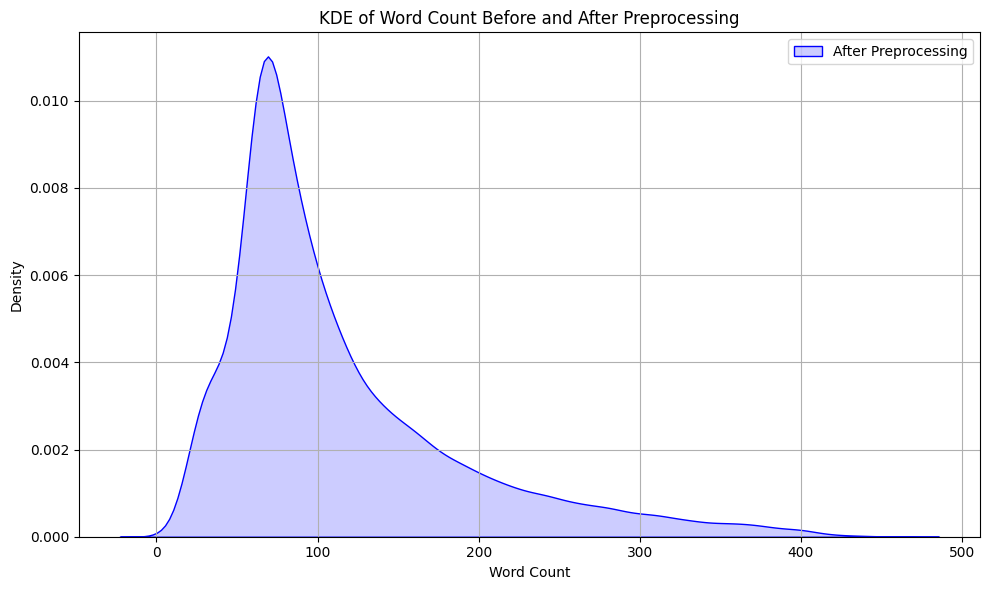

In [14]:
df['processed_length'] = df['processed_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.kdeplot(df['processed_length'], color='blue', label='After Preprocessing', fill=True, alpha=0.2)

plt.xlabel('Word Count')
plt.ylabel('Density')
plt.title('KDE of Word Count Before and After Preprocessing')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


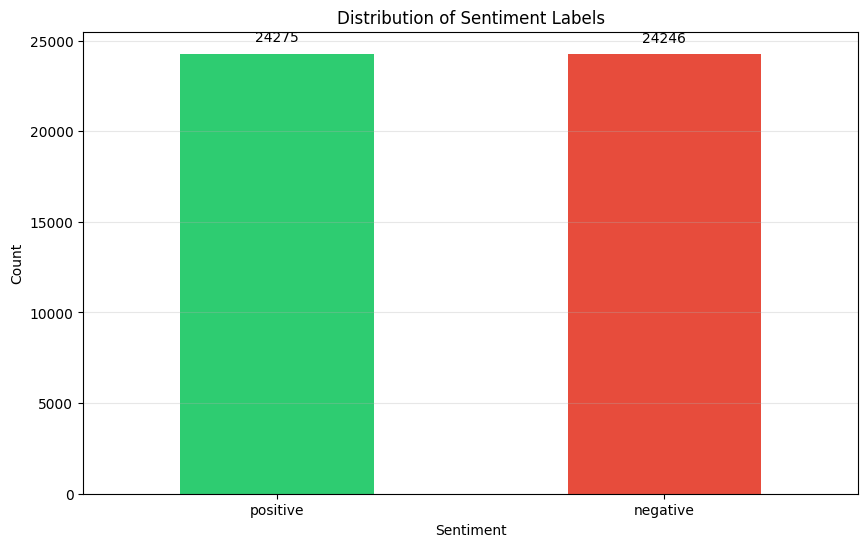

In [15]:
count_label = df['sentiment'].value_counts()

plt.figure(figsize=(10, 6))
bars = count_label.plot(kind='bar', color=['#2ecc71', '#e74c3c'] )
for i, v in enumerate(count_label):
    plt.text(i, v + 500, str(v), ha='center', va='bottom')


plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='-', alpha=0.3)
plt.show()

### ***Training***

#### ***Split data***

In [16]:
# Encoding label
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# Split data
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    df['processed_text'], df['sentiment'], test_size=0.3, random_state=42, stratify=df['sentiment']
)
# Split the temp data into test and validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 33964
Validation set size: 10189
Test set size: 4368


#### ***Tokeniztion & preparing data for transformer***

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
from transformers import RobertaConfig, RobertaTokenizer, RobertaForSequenceClassification

model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
config = RobertaConfig.from_pretrained(
    model_name,
    num_labels=2,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3,
    output_attentions=False,
    output_hidden_states=False,
)

model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

model.to(device)


def tokenize_data(texts, labels, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.values, dtype=torch.long)
    
    return input_ids, attention_masks, labels

train_inputs, train_masks, train_labels = tokenize_data(X_train, y_train, tokenizer)
val_inputs, val_masks, val_labels = tokenize_data(X_val, y_val, tokenizer)
test_inputs, test_masks, test_labels = tokenize_data(X_test, y_test, tokenizer)

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


Using device: cuda


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### ***Train***

In [18]:
#  Optimizer , Scheduler
epochs = 50
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8, weight_decay=0.01)
total_steps = len(train_dataloader) * epochs
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, total_steps)

# Training Function with Early Stopping
def train_model(model, train_dataloader, val_dataloader, epochs, optimizer, scheduler, device, save_path="best_model.pt"):
    best_val_acc = 0
    training_stats = []
    best_weights = None
    early_stop_patience = 5
    epochs_no_improve = 0
    early_stopped = False

    for epoch in range(epochs):
        print(f"\n Epoch {epoch + 1} / {epochs} ===")

        model.train()
        total_train_loss = 0
        train_preds = []
        train_labels = []

        for batch in tqdm(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()
            outputs = model(
                b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )

            loss = outputs.loss
            logits = outputs.logits
            total_train_loss += loss.item()

            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            labels = b_labels.detach().cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = accuracy_score(train_labels, train_preds)

        # Validation
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(val_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(
                    b_input_ids,
                    attention_mask=b_input_mask,
                    labels=b_labels
                )

            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = b_labels.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f"Epoch {epoch+1:02} | Train Acc: {train_accuracy:.4f} | Train Loss: {avg_train_loss:.4f} |  Val Acc: {val_accuracy:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early Stopping
        if val_accuracy > best_val_acc:
            print(f"New best val_accuracy: {val_accuracy:.4f} (improved from {best_val_acc:.4f})")
            best_val_acc = val_accuracy
            best_weights = model.state_dict()
            torch.save(best_weights, save_path)
            print(f"Best model saved to {save_path}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement in val_accuracy. ({epochs_no_improve}/{early_stop_patience})")
            if epochs_no_improve >= early_stop_patience:
                print(f"Early stopping triggered after {early_stop_patience} epochs without improvement.")
                early_stopped = True
                break

        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        })

    if early_stopped:
        print("Training was stopped early due to no improvement in validation loss.")

    return training_stats

training_stats = train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs=epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device
)



 Epoch 1 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.58it/s]


Epoch 01 | Train Acc: 0.5813 | Train Loss: 0.6504 |  Val Acc: 0.8508 | Val Loss: 0.3631
New best val_accuracy: 0.8508 (improved from 0.0000)
Best model saved to best_model.pt

 Epoch 2 / 50 ===


100%|██████████| 319/319 [01:10<00:00,  4.54it/s]


Epoch 02 | Train Acc: 0.8366 | Train Loss: 0.3827 |  Val Acc: 0.8852 | Val Loss: 0.3137
New best val_accuracy: 0.8852 (improved from 0.8508)
Best model saved to best_model.pt

 Epoch 3 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.56it/s]


Epoch 03 | Train Acc: 0.8564 | Train Loss: 0.3334 |  Val Acc: 0.8943 | Val Loss: 0.2697
New best val_accuracy: 0.8943 (improved from 0.8852)
Best model saved to best_model.pt

 Epoch 4 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.58it/s]


Epoch 04 | Train Acc: 0.8706 | Train Loss: 0.3069 |  Val Acc: 0.8968 | Val Loss: 0.2941
New best val_accuracy: 0.8968 (improved from 0.8943)
Best model saved to best_model.pt

 Epoch 5 / 50 ===


100%|██████████| 319/319 [01:10<00:00,  4.55it/s]


Epoch 05 | Train Acc: 0.8797 | Train Loss: 0.2901 |  Val Acc: 0.8957 | Val Loss: 0.2889
No improvement in val_accuracy. (1/5)

 Epoch 6 / 50 ===


100%|██████████| 319/319 [01:10<00:00,  4.55it/s]


Epoch 06 | Train Acc: 0.8858 | Train Loss: 0.2759 |  Val Acc: 0.9060 | Val Loss: 0.2530
New best val_accuracy: 0.9060 (improved from 0.8968)
Best model saved to best_model.pt

 Epoch 7 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.60it/s]


Epoch 07 | Train Acc: 0.8947 | Train Loss: 0.2597 |  Val Acc: 0.9107 | Val Loss: 0.2605
New best val_accuracy: 0.9107 (improved from 0.9060)
Best model saved to best_model.pt

 Epoch 8 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.59it/s]


Epoch 08 | Train Acc: 0.9020 | Train Loss: 0.2440 |  Val Acc: 0.9066 | Val Loss: 0.2741
No improvement in val_accuracy. (1/5)

 Epoch 9 / 50 ===


100%|██████████| 319/319 [01:10<00:00,  4.55it/s]


Epoch 09 | Train Acc: 0.9078 | Train Loss: 0.2309 |  Val Acc: 0.9117 | Val Loss: 0.2613
New best val_accuracy: 0.9117 (improved from 0.9107)
Best model saved to best_model.pt

 Epoch 10 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.57it/s]


Epoch 10 | Train Acc: 0.9139 | Train Loss: 0.2181 |  Val Acc: 0.9136 | Val Loss: 0.2671
New best val_accuracy: 0.9136 (improved from 0.9117)
Best model saved to best_model.pt

 Epoch 11 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.57it/s]


Epoch 11 | Train Acc: 0.9187 | Train Loss: 0.2087 |  Val Acc: 0.9152 | Val Loss: 0.3049
New best val_accuracy: 0.9152 (improved from 0.9136)
Best model saved to best_model.pt

 Epoch 12 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.57it/s]


Epoch 12 | Train Acc: 0.9222 | Train Loss: 0.2013 |  Val Acc: 0.9130 | Val Loss: 0.2896
No improvement in val_accuracy. (1/5)

 Epoch 13 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.57it/s]


Epoch 13 | Train Acc: 0.9291 | Train Loss: 0.1894 |  Val Acc: 0.9160 | Val Loss: 0.2609
New best val_accuracy: 0.9160 (improved from 0.9152)
Best model saved to best_model.pt

 Epoch 14 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.59it/s]


Epoch 14 | Train Acc: 0.9301 | Train Loss: 0.1807 |  Val Acc: 0.9119 | Val Loss: 0.3061
No improvement in val_accuracy. (1/5)

 Epoch 15 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.57it/s]


Epoch 15 | Train Acc: 0.9347 | Train Loss: 0.1723 |  Val Acc: 0.9171 | Val Loss: 0.2706
New best val_accuracy: 0.9171 (improved from 0.9160)
Best model saved to best_model.pt

 Epoch 16 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.56it/s]


Epoch 16 | Train Acc: 0.9395 | Train Loss: 0.1653 |  Val Acc: 0.9149 | Val Loss: 0.3244
No improvement in val_accuracy. (1/5)

 Epoch 17 / 50 ===


100%|██████████| 319/319 [01:10<00:00,  4.55it/s]


Epoch 17 | Train Acc: 0.9448 | Train Loss: 0.1535 |  Val Acc: 0.9141 | Val Loss: 0.2869
No improvement in val_accuracy. (2/5)

 Epoch 18 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.57it/s]


Epoch 18 | Train Acc: 0.9473 | Train Loss: 0.1470 |  Val Acc: 0.9133 | Val Loss: 0.3452
No improvement in val_accuracy. (3/5)

 Epoch 19 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.59it/s]


Epoch 19 | Train Acc: 0.9497 | Train Loss: 0.1408 |  Val Acc: 0.9170 | Val Loss: 0.3022
No improvement in val_accuracy. (4/5)

 Epoch 20 / 50 ===


100%|██████████| 319/319 [01:09<00:00,  4.56it/s]

Epoch 20 | Train Acc: 0.9521 | Train Loss: 0.1341 |  Val Acc: 0.9143 | Val Loss: 0.3437
No improvement in val_accuracy. (5/5)
Early stopping triggered after 5 epochs without improvement.
Training was stopped early due to no improvement in validation loss.


### ***Evalution***

#### ***Learning Curve***

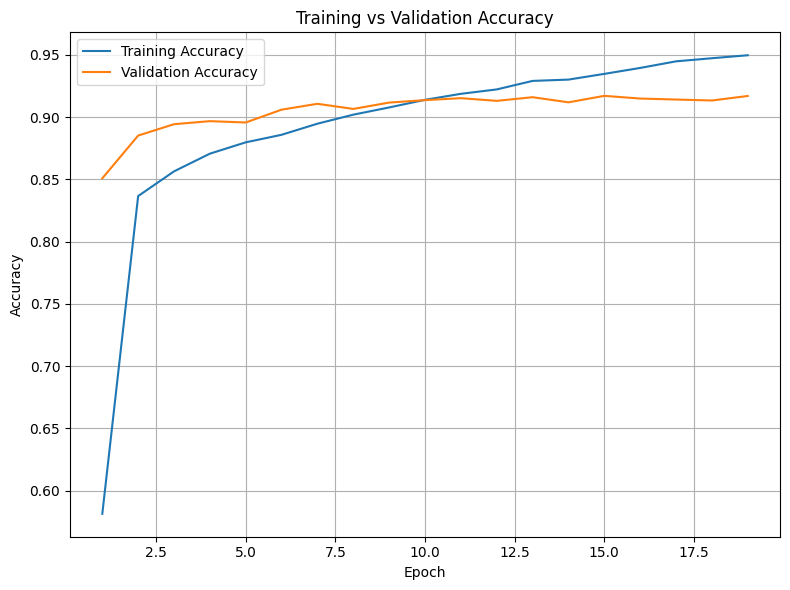

In [19]:
# Plot Training & Validation Accuracy
import matplotlib.pyplot as plt

train_acc = [stat['train_accuracy'] for stat in training_stats]
val_acc = [stat['val_accuracy'] for stat in training_stats]
epochs_range = [stat['epoch'] for stat in training_stats]

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


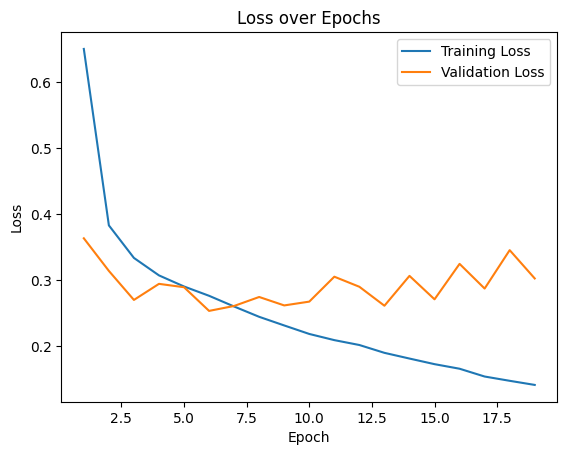

In [20]:
# Example: Plotting training and validation loss
import matplotlib.pyplot as plt

train_loss = [stat['train_loss'] for stat in training_stats]
val_loss = [stat['val_loss'] for stat in training_stats]
epochs_range = [stat['epoch'] for stat in training_stats]

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


#### ***Classificatio Report***

In [21]:

def evaluate_test_set(model, test_dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in tqdm(test_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask
            )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        labels = b_labels.detach().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    print("\nClassification Report:")
    print(report)

    print("Confusion Matrix:")
    print(cm)
    

    return accuracy, precision, recall, f1 ,all_labels ,all_preds


acc ,precision ,recall ,f1 ,labels ,preds=  evaluate_test_set(model, test_dataloader, device)


100%|██████████| 137/137 [00:30<00:00,  4.50it/s]


Classification Report:
              precision    recall  f1-score   support

           0     0.9123    0.9198    0.9161      2183
           1     0.9192    0.9117    0.9154      2185

    accuracy                         0.9158      4368
   macro avg     0.9158    0.9158    0.9157      4368
weighted avg     0.9158    0.9158    0.9157      4368

Confusion Matrix:
[[2008  175]
 [ 193 1992]]


#### ***Confusion Matrix***

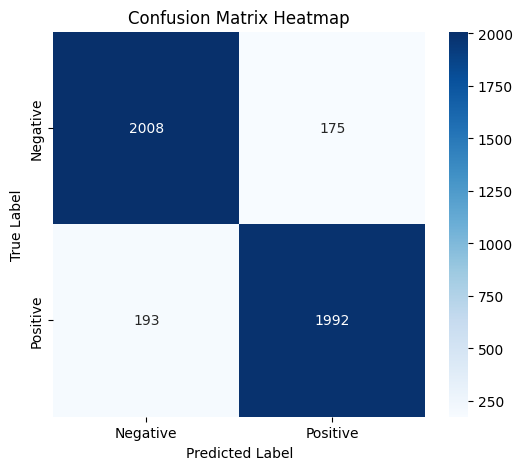

In [22]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative',  'Positive'],
            yticklabels=['Negative',  'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.savefig("confusion_matrix_heatmap.png")
plt.show()

#### ***Text Example***

In [23]:
def predict_sentiment(text, model, tokenizer, device):
    # Preprocess the text
    processed_text = preprocess_text(text)
    
    # Tokenize
    encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
    
    # Move to device
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Get prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    # Get prediction class
    prediction = torch.argmax(logits, dim=1).item()
    
    # Map prediction to sentiment
    sentiment_map = {0: 'Negative', 1: 'positive'}
    sentiment = sentiment_map[prediction]
    
    return sentiment

# Example usage
sample_texts = [
    "I absolutely love this product! It's amazing!",
    "This is the worst experience I've ever had."
]

for text in sample_texts:
    sentiment = predict_sentiment(text, model, tokenizer, device)
    print(f"Text: {text}")
    print(f"Sentiment: {sentiment}\n")

Text: I absolutely love this product! It's amazing!
Sentiment: positive

Text: This is the worst experience I've ever had.
Sentiment: Negative



#### ***Save model***

In [24]:
# Thư mục để lưu mô hình
save_directory = "roberta_model_ft"
os.makedirs(save_directory, exist_ok=True)

# Save model weights, config, and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to roberta_model_ft


In [25]:
import shutil
shutil.make_archive("roberta_model", 'zip', "roberta_model_ft")

'/kaggle/working/roberta_model.zip'